## Final Class

In [27]:
import os
import random

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.functional import softmax

from transformers import AutoTokenizer, AutoModelForSequenceClassification

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

from typing import List, Dict, Tuple, Optional


class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int = 32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
        )
    def forward(self, x):
        z = self.encoder(x)
        xrec = self.decoder(z)
        return xrec, z


class MechanisticInterpretation:
    def __init__(
        self,
        model_name: str,
        window_size: int,
        model_path: str,
        device: str = None
    ):
        """
        model_name: "NT", "DNABERT6", or "GROVER"
        window_size: upstream/downstream window size (for metadata)
        model_path: local path to your fine-tuned model directory
        device: 'cuda' or 'cpu'
        """
        self.model_name  = model_name
        self.window_size = window_size
        self.model_path  = model_path
        self.device      = device or ("cuda" if torch.cuda.is_available() else "cpu")

        # 1) load tokenizer, then read its model_max_length (just for info)
        self.tokenizer = AutoTokenizer.from_pretrained(
            self.model_path,
            local_files_only=True,
            trust_remote_code=True
        )
        print(f"ℹ️  tokenizer.model_max_length = {self.tokenizer.model_max_length}")

        # 2) load model
        self.model = AutoModelForSequenceClassification.from_pretrained(
            self.model_path,
            local_files_only=True,
            trust_remote_code=True,
            output_attentions=True,
            output_hidden_states=True
        ).to(self.device)
        self.model.eval()

        # 3) handy refs
        self.base_model = getattr(self.model, self.model.base_model_prefix)
        self.layers     = self.base_model.encoder.layer
        self.pooler     = getattr(self.base_model, "pooler", None)
        self.classifier = self.model.classifier

    def load_data(self, tsv_path: str):
        """Load sequences and labels from a ClinVar TSV file."""
        df = pd.read_csv(tsv_path, sep="\t", dtype=str)
        self.sequences = df["Sequence"].tolist()
        self.labels    = df.get("is_pathogenic", []).astype(int).tolist()
        return df

    def tokenize(self, sequences: list):
        """
        Tokenize a list of DNA sequences *without* any truncation.
        This will preserve the full window length.
        """
        return (
            self.tokenizer(
                sequences,
                padding="longest",
                truncation=False,   # ⚠️  DO NOT truncate
                return_tensors="pt"
            )
            .to(self.device)
        )

    def token_length_stats(self, sequences: list = None):
        """
        Tokenize each sequence and print a quick describe() on lengths.
        """
        seqs = sequences if sequences is not None else getattr(self, "sequences", None)
        if seqs is None:
            raise ValueError("No sequences to measure; run .load_data() first.")
        lengths = []
        for s in seqs:
            toks = self.tokenize([s])["input_ids"][0]
            lengths.append(toks.shape[0])
        ser = pd.Series(lengths)
        print("Tokenized sequence-length stats:")
        print(ser.describe())
        return ser

    def predict(self, sequences: list):
        inputs = self.tokenize(sequences)
        with torch.no_grad():
            out   = self.model(**inputs)
            probs = softmax(out.logits, dim=-1)
        return probs.cpu().numpy()

    def get_attention_maps(self, sequence: str):
        inputs = self.tokenize([sequence])
        with torch.no_grad():
            outputs = self.model(**inputs)
        return [attn[0].cpu().numpy() for attn in outputs.attentions]

    def plot_attention(self, sequence: str, layer: int = -1, head: int = None):
        A = self.get_attention_maps(sequence)[layer]
        if head is not None:
            A = A[head]
            title = f"{self.model_name} head {head}, layer {layer}"
        else:
            A = A.mean(axis=0)
            title = f"{self.model_name} avg heads, layer {layer}"
        plt.figure(figsize=(6,5), facecolor="white")
        plt.imshow(A, aspect="auto", cmap="viridis")
        plt.colorbar(label="attention weight")
        plt.title(title)
        plt.xlabel("Key position")
        plt.ylabel("Query position")
        plt.show()

    def patch_activation(self, source_seq: str, target_seq: str, layer_num: int, positions: list):
        # tokenize
        src_inputs = self.tokenize([source_seq])
        tgt_inputs = self.tokenize([target_seq])
        # forward
        with torch.no_grad():
            src_out = self.model(**src_inputs)
            tgt_out = self.model(**tgt_inputs)
        src_hs = src_out.hidden_states
        tgt_hs = tgt_out.hidden_states
        orig_p = softmax(src_out.logits, dim=-1)[0,1].item()
        # patch
        patched_hs = list(src_hs)
        layer_act  = patched_hs[layer_num].clone()
        layer_act[0, positions, :] = tgt_hs[layer_num][0, positions, :]
        patched_hs[layer_num] = layer_act
        patched_hs          = tuple(patched_hs)
        # forward the rest
        hidden = patched_hs[layer_num]
        mask   = src_inputs["attention_mask"]
        for L in range(layer_num+1, len(self.layers)):
            hidden = self.layers[L](hidden, mask)[0]
        # pool & classify
        if self.pooler:
            pooled_vec = self.pooler(hidden)
        else:
            pooled_vec = hidden[:,0]
        pooled = pooled_vec.unsqueeze(1)
        logits = self.classifier(pooled)
        pat_p  = softmax(logits, dim=-1)[0,1].item()
        return orig_p, pat_p

    def find_critical_positions(self, sequence: str, reference_seq: str, layer: int):
        tokenized  = self.tokenize([sequence])["input_ids"][0]
        seq_len    = tokenized.shape[0]
        importances = []
        for pos in range(seq_len):
            o,p = self.patch_activation(sequence, reference_seq, layer, [pos])
            importances.append(o-p)
        return np.array(importances)

    def find_critical_layer(self, sequence: str, reference_seq: str, positions: list):
        return [(L, *self.patch_activation(sequence, reference_seq, L, positions))
                for L in range(len(self.layers))]

    def fit_sparse_autoencoder(
        self,
        embeddings: np.ndarray,
        sample_ids: list,
        latent_dim: int = 32,
        l1_lambda: float = 1e-3,
        lr: float = 1e-3,
        batch_size: int = 4,
        epochs: int = 50,
    ) -> torch.Tensor:
        """
        Train a sparse autoencoder on `embeddings` (shape [N, D]) and
        return Z_sample (torch.Tensor [N, latent_dim]).
        """
        seed = 42
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        # if using CUDA:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark     = False

        class SAE(nn.Module):
            def __init__(self, D, L):
                super().__init__()
                self.encoder = nn.Sequential(
                    nn.Linear(D, 128), nn.ReLU(),
                    nn.Linear(128, L), nn.ReLU(),
                )
                self.decoder = nn.Sequential(
                    nn.Linear(L, 128), nn.ReLU(),
                    nn.Linear(128, D),
                )
            def forward(self, x):
                z    = self.encoder(x)
                xrec = self.decoder(z)
                return xrec, z

        X = torch.from_numpy(embeddings).float()
        dset  = TensorDataset(X)
        loader = DataLoader(dset, batch_size=batch_size, shuffle=True)

        ae = SAE(embeddings.shape[1], latent_dim).to(self.device)
        opt = torch.optim.Adam(ae.parameters(), lr=lr)
        mse = nn.MSELoss()

        for ep in range(epochs):
            total_loss = 0.0
            for (xb,) in loader:
                xb = xb.to(self.device)
                xrec, z = ae(xb)
                loss = mse(xrec, xb) + l1_lambda * z.abs().mean()
                opt.zero_grad()
                loss.backward()
                opt.step()
                total_loss += loss.item() * xb.size(0)
            print(f"Epoch {ep+1:>3d} | avg loss = {total_loss/len(X):.4f}")

        with torch.no_grad():
            _, Z = ae(X.to(self.device))
        # return Z in CPU for downstream
        return Z.cpu()

    def extract_and_write_latent_fastas(
        self,
        Z: torch.Tensor,
        df_samples: pd.DataFrame,
        embeddings_ids: list,
        top_dims: list,
        out_dir: str,
        flank: int = 25
    ):
        """
        Given Z [N, L], writes:
          • top10_z{d}.fasta  (full windows)
          • top10_z{d}_trimmed.fasta  (center ± flank)
        """
        os.makedirs(out_dir, exist_ok=True)
        # assemble DataFrame
        Zdf = pd.DataFrame(
            Z.numpy(),
            index=embeddings_ids,
            columns=[f"z{i}" for i in range(Z.size(1))]
        )
        # bring in group & sequence
        seq_map = df_samples.set_index("VariationID")["Sequence"].to_dict()
        grp_map = df_samples.set_index("VariationID")["group"].to_dict()

        for d in top_dims:
            col = f"z{d}"
            top_ids = Zdf[col].nlargest(10).index.tolist()

            # write full‐length FASTA
            full_fa = os.path.join(out_dir, f"top10_{col}.fasta")
            recs = []
            for vid in top_ids:
                recs.append(SeqRecord(
                    Seq(seq_map[vid]),
                    id=str(vid),
                    description=f"{col}={Zdf.at[vid,col]:.3f}"
                ))
            SeqIO.write(recs, full_fa, "fasta")

            # write trimmed FASTA
            trim_fa = os.path.join(out_dir, f"top10_{col}_trimmed.fasta")
            recs2 = []
            for r in recs:
                seq = str(r.seq)
                c   = len(seq)//2
                sub = seq[c-flank:c+flank+1]
                recs2.append( SeqRecord(Seq(sub),
                                         id=r.id,
                                         description=r.description) )
            SeqIO.write(recs2, trim_fa, "fasta")

            print(f"Wrote {len(recs)} full & trimmed for {col}")

    def get_sae_means(
        self,
        Z: torch.Tensor,
        df_samples: pd.DataFrame,
        embeddings_ids: List[str],
    ) -> pd.DataFrame:
        Zdf = pd.DataFrame(
            Z.cpu().numpy(),
            index=embeddings_ids,
            columns=[f"z{i}" for i in range(Z.size(1))]
        )
        Zdf["group"] = df_samples.set_index("VariationID") \
                                .loc[embeddings_ids, "group"].values
        means = Zdf.groupby("group").mean().T
        return means

    def plot_sae_features(
        self,
        Z: torch.Tensor,
        df_samples: pd.DataFrame,
        embeddings_ids: List[str],
        top_n: int = 5,
        figsize: Tuple[int,int] = (6,4),
        return_table: bool = False
    ) -> Optional[pd.DataFrame]:
        # build the Zdf
        Zdf = pd.DataFrame(
            Z.cpu().numpy(),
            index=embeddings_ids,
            columns=[f"z{i}" for i in range(Z.size(1))]
        )
        Zdf["group"] = df_samples.set_index("VariationID") \
                                .loc[embeddings_ids, "group"].values

        # compute per‐group means
        means = Zdf.groupby("group").mean().T

        # plot top‐N
        diff     = (means["Correct"] - means["Incorrect"]).abs()
        top_dims = diff.nlargest(top_n).index
        ax = means.loc[top_dims].plot(
            kind="barh",
            figsize=figsize,
            title=f"Top {top_n} SAE features distinguishing groups"
        )
        ax.set_xlabel("Mean latent activation")
        plt.tight_layout()
        plt.show()

        if return_table:
            return means

    def find_top_head_for_layer(
        self,
        sequences: List[str],
        layer_idx: int,
        variant_token_pos: Optional[int] = None
    ) -> int:
        """
        For a given transformer layer, scan all heads and return the head index
        whose attention to the variant position is highest on average across `sequences`.
        
        If variant_token_pos is None, we assume the variant is at the center of each tokenized sequence.
        """
        # accumulate per-head scores
        attn_sums = None
        counts    = 0

        for seq in sequences:
            # get the attention map for this one sequence
            attns = self.get_attention_maps(seq)[layer_idx]  # shape [num_heads, Q, K]

            # figure out which token is the "variant"
            if variant_token_pos is None:
                L = attns.shape[-1]
                var_pos = L // 2
            else:
                var_pos = variant_token_pos

            # take attention from CLS→variant: that's head[:, 0 (CLS), var_pos]
            head_scores = attns[:, 0, var_pos]  # shape [num_heads]

            if attn_sums is None:
                attn_sums = head_scores.copy()
            else:
                attn_sums += head_scores

            counts += 1

        # average
        avg_scores = attn_sums / counts  # still a numpy array

        # return the head with max mean score
        return int(np.argmax(avg_scores))
    
    def _mask_head_hook(self, layer_idx: int, head_idx: int):
        """
        Returns a forward hook function that zeroes out the attention weights
        for the specified (layer_idx, head_idx).
        """
        def hook(module, input, output):
            # module here is e.g. BertSelfAttention or similar
            # output is a tuple: (attn_output, attn_weights)
            attn_output, attn_probs = output
            # attn_probs: [batch, n_heads, seq_len, seq_len]
            attn_probs = attn_probs.clone()
            attn_probs[:, head_idx, :, :] = 0.0
            # re‐compute attn_output = probs @ value
            # we can get the value tensors via module
            # but HF modules provide a helper: output_attentions=True
            # so simplest is to re‐call the attention operation:
            # unfortunately HF doesn't expose a simple recompute, so instead:
            # we know attn_output = module.dropout(attn_probs @ v)
            v = module.value(module.transpose_for_scores(input[0]))  # hacky
            new_attn_output = torch.einsum("bhij,bjhd->bihd", attn_probs, v)
            new_attn_output = module.dense(new_attn_output.reshape(new_attn_output.size(0), -1, module.all_head_size))
            return new_attn_output, attn_probs
        return hook

    def mask_attention_head(
        self,
        inputs: Dict[str, torch.Tensor],
        layer_idx: int,
        head_idx: int
    ) -> float:
        """
        Zero out the attention scores for one head at inference time
        by passing a head_mask to the model, then return the pathogenic prob.
        """
        # build a head mask of all ones
        # shape: (num_layers, num_heads)
        num_layers = len(self.layers)
        num_heads  = self.layers[0].attention.self.num_attention_heads
        head_mask = torch.ones((num_layers, num_heads), device=self.device)
        head_mask[layer_idx, head_idx] = 0.0

        # call the model with head_mask
        with torch.no_grad():
            out = self.model(
                input_ids      = inputs["input_ids"],
                attention_mask = inputs["attention_mask"],
                head_mask      = head_mask,
                output_attentions=False,
                output_hidden_states=False,
            )
            p = softmax(out.logits, dim=-1)[0,1].item()
        return p

    def ablate_heads(
        self,
        sequences: List[str],
        layer_idx: int,
        head_idx: int
    ) -> float:
        # 1) tokenize *with* attention_mask
        inputs = self.tokenize(sequences)

        # 2) baseline probs
        with torch.no_grad():
            out        = self.model(**inputs)
            base_probs = softmax(out.logits, dim=-1)[:,1].cpu().numpy()

        # 3) masked, one example at a time
        masked = []
        for i in range(len(sequences)):
            single = {k: v[i:i+1] for k,v in inputs.items()}
            p = self.mask_attention_head(single, layer_idx, head_idx)
            masked.append(p)

        return float((base_probs - np.array(masked)).mean())

### Create Sample Variants for downstream analyses
Run this once only

In [ ]:
'''
import os
import pandas as pd

# 1) Load the predictions file directly (it already contains all metadata + embeddings)
preds = pd.read_csv("./results/NT_225bp/NT_225bp_LR_predictions_test.csv", dtype=str)

# 2) Convert numeric columns
preds["actual_label"] = preds["is_pathogenic"].astype(int)
preds["prediction"]   = preds["prediction"].astype(int)

# 3) Flag correct vs incorrect
preds["correct"] = preds["actual_label"] == preds["prediction"]

# 4) Define the columns you want to keep (including embeddings and metadata present in preds)
columns_to_keep = [
    "VariationID", "VariationName", "VariantType", "CanonicalSPDI",
    "GeneSymbol", "OMIM", "AssemblyChr", "Start", "Stop",
    "RefAlleleVCF", "AltAlleleVCF", "VariantLength",
    "ProteinChange", "HGVS_coding", "HGVS_protein",
    "DateLastUpdated", "NumberOfSubmitters", "RecordType",
    "CLNSIG", "actual_label", "prediction",
    "clinvar_group", "Contig", "WindowStart", "WindowEnd",
    "Sequence", "clinvar_binary"
] + [col for col in preds.columns if col.startswith("emb_")]

# 5) Create output directory if not exists
out_dir = "./results/NT_225bp/mechanistic_interpretation"
os.makedirs(out_dir, exist_ok=True)

# 6) Split into correct and incorrect
correct_df   = preds[preds["correct"]][columns_to_keep].reset_index(drop=True)
incorrect_df = preds[~preds["correct"]][columns_to_keep].reset_index(drop=True)

# 7) Save full lists or sample if desired
correct_df.to_csv(f"{out_dir}/correct_variants_all.csv", index=False)
incorrect_df.to_csv(f"{out_dir}/incorrect_variants_all.csv", index=False)

# 8) Optionally sample up to 5 of each for quick review
sample_n = 10
correct_sample   = correct_df.sample(n=min(sample_n, len(correct_df)), random_state=42)
incorrect_sample = incorrect_df.sample(n=min(sample_n, len(incorrect_df)), random_state=42)

print(correct_sample)
print(incorrect_sample)

correct_sample.to_csv(f"{out_dir}/correct_variants_sample.csv", index=False)
incorrect_sample.to_csv(f"{out_dir}/incorrect_variants_sample.csv", index=False)

print(f"Saved {len(correct_df)} correct and {len(incorrect_df)} incorrect variants.")
print(f"Samples saved to:\n  {out_dir}/correct_variants_sample.csv\n  {out_dir}/incorrect_variants_sample.csv")
'''

## Attention Visualization

In [12]:
# ── Block 1: Attention Visualization ─────────────────────────────────────
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.gridspec import GridSpec
import seaborn as sns

# Instantiate once
interp = MechanisticInterpretation(
    model_name="NT",
    window_size=512,
    model_path="./finetuned_models/nucleotide_transformer_pathogenic_classifier_225",
    device="cpu"
)

# Load your 10-row samples
base_dir      = "./results/NT_225bp/mechanistic_interpretation"
correct_df    = pd.read_csv(os.path.join(base_dir, "correct_variants_sample.csv"),   dtype=str)
incorrect_df  = pd.read_csv(os.path.join(base_dir, "incorrect_variants_sample.csv"), dtype=str)
correct_df["group"], incorrect_df["group"] = "Correct", "Incorrect"
df = pd.concat([correct_df, incorrect_df], ignore_index=True)

# Helper to find top head
def find_top_head(seq):
    toks    = interp.tokenize([seq])["input_ids"][0]
    var_pos = toks.shape[0] // 2
    attns   = interp.get_attention_maps(seq)
    best    = (0.0, 0, 0)
    for L, layer_attn in enumerate(attns):
        for H in range(layer_attn.shape[0]):
            score = layer_attn[H, 0, var_pos]
            if score > best[0]:
                best = (score, L, H)
    return best

meta_cols = [
    "VariationID", "VariationName", "VariantType", "GeneSymbol", "OMIM",
    "AssemblyChr", "Start", "Stop", "RefAlleleVCF", "AltAlleleVCF",
    "VariantLength", "ProteinChange", "HGVS_coding", "HGVS_protein",
    "DateLastUpdated", "NumberOfSubmitters", "RecordType", "CLNSIG",
    "actual_label", "prediction"
]
out_pdf = os.path.join(base_dir, "attention_with_metadata.pdf")
with PdfPages(out_pdf) as pdf:
    for _, row in df.iterrows():
        score, layer, head = find_top_head(row["Sequence"])

        # Build text block
        lines = [f"--- {row['group']}ly Predicted Variant ---",
                 f"Top head → layer {layer}, head {head}, score {score:.4f}", ""]
        for c in meta_cols:
            lines.append(f"{c}: {row.get(c,'')}")
        text_block = "\n".join(lines)

        # New: make text panel wider and add more wspace
        fig = plt.figure(figsize=(12, 6), facecolor="white")
        gs  = GridSpec(1, 2,
                       width_ratios=[1.3, 2],   # increased left panel ratio
                       wspace=0.3,              # more horizontal padding
                       figure=fig)

        # extra left margin
        fig.subplots_adjust(left=0.05)

        # Left: metadata
        ax0 = fig.add_subplot(gs[0])
        ax0.axis("off")
        ax0.text(0, 1, text_block,
                 va="top", ha="left",
                 family="monospace", fontsize=9)

        # Right: attention map
        attn = interp.get_attention_maps(row["Sequence"])[layer][head]
        ax1  = fig.add_subplot(gs[1])
        #im   = ax1.imshow(attn, aspect="auto", cmap="Blues")
        im = ax1.imshow(attn, aspect="auto", cmap="viridis")
        fig.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
        ax1.set_title(f"{row['group']} | Var {row['VariationID']}")
        ax1.set_xlabel("Key position")
        ax1.set_ylabel("Query position")

        pdf.savefig(fig, facecolor=fig.get_facecolor())
        plt.close(fig)

print("Saved combined attention+metadata PDF to", out_pdf)

ℹ️  tokenizer.model_max_length = 1000


/cluster/home/t131303uhn/anaconda3/envs/dna_bert2/lib/python3.8/site-packages/transformers/modeling_utils.py:446: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.

Saved combined attention+metadata PDF to ./results/NT_225bp/mechanistic_interpretation/attention_with_metadata.pdf


In [15]:
# First, rerun find_top_head for every sequence, storing results
records = []
for _, row in df.iterrows():
    score, layer, head = find_top_head(row["Sequence"])
    records.append({
        "VariationID": row["VariationID"],
        "group":       row["group"],
        "layer":       layer,
        "head":        head,
        "score":       score
    })
tops = pd.DataFrame(records)

# 1) Print human-readable summary:
print("\n=== Correctly predicted ===")
'''
for _, r in tops[tops.group=="Correct"].sort_values("score", ascending=False).iterrows():
    print(f"Var {r.VariationID} → L{r.layer}–H{r.head} ({r.score:.4f})")

print("\n=== Incorrectly predicted ===")
for _, r in tops[tops.group=="Incorrect"].sort_values("score", ascending=False).iterrows():
    print(f"Var {r.VariationID} → L{r.layer}–H{r.head} ({r.score:.4f})")
'''
# 2) Bar-plot of layer counts by group
plt.figure(figsize=(8,4))
sns.countplot(
    data=tops,
    x="layer",
    hue="group",
    palette={"Correct":"C0","Incorrect":"C1"}
)
plt.title("Distribution of Top-Attention Heads Across Layers")
plt.xlabel("Layer index")
plt.ylabel("Count of variants")
plt.legend(title="Prediction")
plt.tight_layout()
plt.savefig(os.path.join(base_dir, "attention_layer_distribution.png"))
plt.close()

print("Saved layer distribution plot to:", 
      os.path.join(base_dir, "attention_layer_distribution.png"))


=== Correctly predicted ===
Saved layer distribution plot to: ./results/NT_225bp/mechanistic_interpretation/attention_layer_distribution.png


## Activation Patching

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# ── 1) Instantiate interpreter ────────────────────────────────────────────────
interp = MechanisticInterpretation(
    model_name="NT",
    window_size=512,  # up/downstream window used in fine‐tuning
    model_path="./finetuned_models/nucleotide_transformer_pathogenic_classifier_225",
    device="cpu"
)

# ── 2) Load your 10‐row sample tables ─────────────────────────────────────────
base_dir     = "./results/NT_225bp/mechanistic_interpretation"
correct_df   = pd.read_csv(os.path.join(base_dir, "correct_variants_sample.csv"),   dtype=str)
incorrect_df = pd.read_csv(os.path.join(base_dir, "incorrect_variants_sample.csv"), dtype=str)
correct_df["group"], incorrect_df["group"] = "Correct", "Incorrect"
df_samples = pd.concat([correct_df, incorrect_df], ignore_index=True)

# ── 3) Prepare output DataFrame ───────────────────────────────────────────────
results = []

# ── 4) Loop through each sample and patch at its true locus ──────────────────
for _, row in df_samples.iterrows():
    seq        = row["Sequence"]
    ref_allele = row["RefAlleleVCF"]

    # ── a) Compute the variant’s 0-based token index inside this window ──────
    WINDOW    = interp.window_size
    win_start = int(row["WindowStart"])   # genomic coord of seq[0]
    var_start = int(row["Start"])         # genomic coord of the first alt base
    var_len   = int(row["VariantLength"]) # length of the alt allele in bp

    # 1) bp offset of the variant from the start of your window:
    var_pos_bp = var_start - win_start

    # 2) convert to token index by dividing by the k-mer size (6 for NT):
    K = 6
    var_pos_tok = var_pos_bp // K

    # 3) build the list of token positions to patch (for indels you might want a small range):
    positions = list(range(var_pos_tok, var_pos_tok + 1))

    # ── b) Reconstruct the reference sequence at that span ────────────────────
    ref_seq = seq[: var_pos_bp ] + ref_allele + seq[var_pos_bp + var_len :]

    # ── c) For each layer, patch only that token position ────────────────────
    for layer_idx in range(len(interp.layers)):
        orig_p, patched_p = interp.patch_activation(
            source_seq=seq,
            target_seq=ref_seq,
            layer_num=layer_idx,
            positions=positions
        )
        results.append({
            "VariationID":   row["VariationID"],
            "group":         row["group"],
            "layer":         layer_idx,
            "orig_prob":     orig_p,
            "patched_prob":  patched_p,
            "delta":         orig_p - patched_p
        })

# ── 5) Save results to CSV ────────────────────────────────────────────────────
out_csv = os.path.join(base_dir, "activation_patching_results.csv")
pd.DataFrame(results).to_csv(out_csv, index=False)
print(f"Patching results saved to {out_csv}")

# ── 6) Quick plot: mean Δ by layer for each group ─────────────────────────────
df_res = pd.DataFrame(results)
fig, ax = plt.subplots(figsize=(8,4))
for grp, grp_df in df_res.groupby("group"):
    mean_delta = grp_df.groupby("layer")["delta"].mean()
    ax.plot(mean_delta.index, mean_delta.values, marker="o", label=grp)
ax.set_xlabel("Layer")
ax.set_ylabel("Mean Δ (orig − patched)")
ax.set_title("Activation‐Patching Impact by Layer")
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(base_dir, "patching_impact_by_layer.png"))
plt.close(fig)
print("Saved patching‐impact plot.")

ℹ️  tokenizer.model_max_length = 1000


/cluster/home/t131303uhn/anaconda3/envs/dna_bert2/lib/python3.8/site-packages/transformers/modeling_utils.py:446: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.

Patching results saved to ./results/NT_225bp/mechanistic_interpretation/activation_patching_results.csv
Saved patching‐impact plot.


## Sparse AutoEncoder (SAE) Analysis

ℹ️  tokenizer.model_max_length = 1000


/cluster/home/t131303uhn/anaconda3/envs/dna_bert2/lib/python3.8/site-packages/transformers/modeling_utils.py:446: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.

Epoch   1 | avg loss = 0.8924
Epoch   2 | avg loss = 0.8003
Epoch   3 | avg loss = 0.6669
Epoch   4 | avg loss = 0.5388
Epoch   5 | avg loss = 0.4289
Epoch   6 | avg loss = 0.3219
Epoch   7 | avg loss = 0.2277
Epoch   8 | avg loss = 0.1505
Epoch   9 | avg loss = 0.0892
Epoch  10 | avg loss = 0.0524
Epoch  11 | avg loss = 0.0337
Epoch  12 | avg loss = 0.0238
Epoch  13 | avg loss = 0.0197
Epoch  14 | avg loss = 0.0185
Epoch  15 | avg loss = 0.0170
Epoch  16 | avg loss = 0.0159
Epoch  17 | avg loss = 0.0159
Epoch  18 | avg loss = 0.0152
Epoch  19 | avg loss = 0.0146
Epoch  20 | avg loss = 0.0148
Epoch  21 | avg loss = 0.0142
Epoch  22 | avg loss = 0.0137
Epoch  23 | avg loss = 0.0148
Epoch  24 | avg loss = 0.0156
Epoch  25 | avg loss = 0.0149
Epoch  26 | avg loss = 0.0141
Epoch  27 | avg loss = 0.0134
Epoch  28 | avg loss = 0.0141
Epoch  29 | avg loss = 0.0140
Epoch  30 | avg loss = 0.0144
Epoch  31 | avg loss = 0.0143
Epoch  32 | avg loss = 0.0138
Epoch  33 | avg loss = 0.0140
Epoch  34 

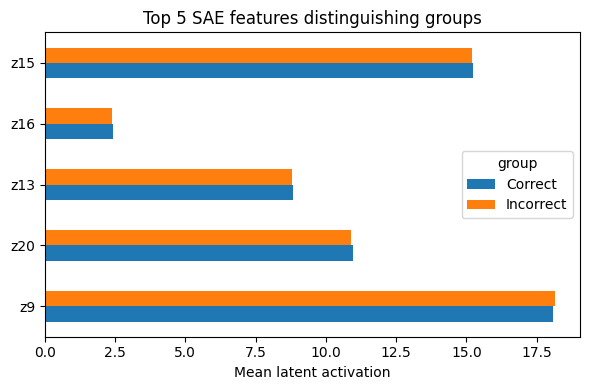

In [5]:
# 1) load your 10+10 samples
base_dir     = "./results/NT_225bp/mechanistic_interpretation"
correct_df   = pd.read_csv(os.path.join(base_dir, "correct_variants_sample.csv"),   dtype=str)
incorrect_df = pd.read_csv(os.path.join(base_dir, "incorrect_variants_sample.csv"), dtype=str)
correct_df["group"], incorrect_df["group"] = "Correct", "Incorrect"
df_samples = pd.concat([correct_df, incorrect_df], ignore_index=True)

interp = MechanisticInterpretation(
    model_name="NT",
    window_size=512,
    model_path="./finetuned_models/nucleotide_transformer_pathogenic_classifier_225",
    device="cpu",
)
# 2) read *all* embeddings
emb_df   = pd.read_csv("./data/embeddings/clinvar_binary_test_embeddings_NT_225.csv", dtype=str)
emb_cols = [c for c in emb_df.columns if c.startswith("emb_")]

# 3) filter to *only* your 20 VariationIDs and reorder to match df_samples
sample_ids = df_samples["VariationID"].astype(str).tolist()
emb_df = (
    emb_df
      .set_index("VariationID")
      .loc[sample_ids]        # picks exactly those 20, in that order
      .reset_index()
)

# 4) build X_sample matrix (20×D)
X_sample = emb_df[emb_cols].astype(float).values      # numpy (20, D)
ids_sample = emb_df["VariationID"].tolist()          # list of 20 IDs

# 5) train your SAE on X_sample only
Z_sample = interp.fit_sparse_autoencoder(
    embeddings = X_sample,
    sample_ids = ids_sample,
    latent_dim = 32,
    l1_lambda  = 1e-3,
    lr         = 1e-3,
    batch_size = 4,
    epochs     = 50,
)

# 6) pick top‐5 dims
Zdf = pd.DataFrame(Z_sample.numpy(), index=ids_sample, columns=[f"z{i}" for i in range(Z_sample.size(1))])
Zdf["group"] = df_samples["group"].values
means = Zdf.groupby("group").mean().T
diff  = (means["Correct"] - means["Incorrect"]).abs()
top5  = [int(c[1:]) for c in diff.nlargest(5).index]

# 7) dump full & trimmed FASTAs for those 5 dims
interp.extract_and_write_latent_fastas(
    Z              = Z_sample,
    df_samples     = df_samples,
    embeddings_ids = ids_sample,
    top_dims       = top5,
    out_dir        = os.path.join(base_dir, "motif_fastas"),
    flank          = 25
)

means = interp.get_sae_means(Z_sample, df_samples, ids_sample)
print(means)
 
# …and if you still want the plot:
interp.plot_sae_features(Z_sample, df_samples, ids_sample)

The code has saved the Fasta samples and their trimmed version in the folder <b>./results/NT_225bp/mechanistic_interpretation/motif_fastas. </b>
I could not install MEME as it depends on a version of Perl that does not exist on Clustre. So I took the sequences and queried at: https://meme-suite.org/meme/tools/meme

## Circuit Ablation

ℹ️  tokenizer.model_max_length = 1000


/cluster/home/t131303uhn/anaconda3/envs/dna_bert2/lib/python3.8/site-packages/transformers/modeling_utils.py:446: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.

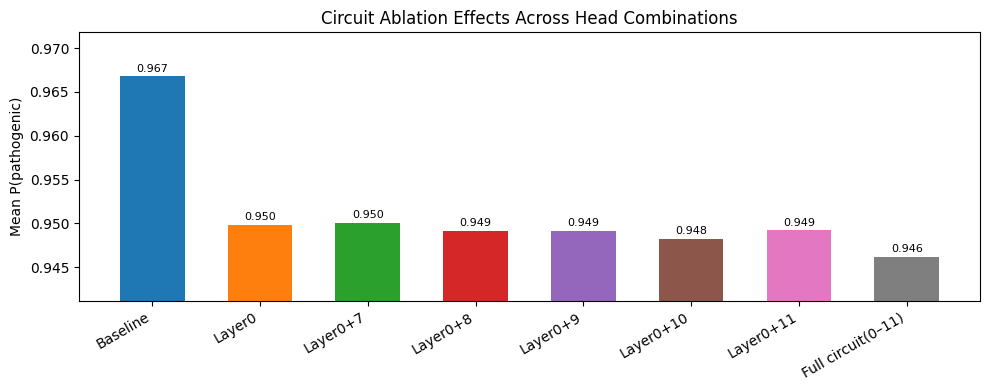

In [33]:
import os
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import softmax

# ── 1) Load your 10+10 variant samples ───────────────────────────────────────
base_dir     = "./results/NT_225bp/mechanistic_interpretation"
correct_df   = pd.read_csv(os.path.join(base_dir, "correct_variants_sample.csv"), dtype=str)
incorrect_df = pd.read_csv(os.path.join(base_dir, "incorrect_variants_sample.csv"), dtype=str)
correct_df["group"], incorrect_df["group"] = "Correct", "Incorrect"
df_samples   = pd.concat([correct_df, incorrect_df], ignore_index=True)
seqs         = df_samples["Sequence"].tolist()

# ── 2) Instantiate interpreter ──────────────────────────────────────────────
interp = MechanisticInterpretation(
    model_name="NT",
    window_size=512,
    model_path="./finetuned_models/nucleotide_transformer_pathogenic_classifier_225",
    device="cpu"
)

# ── 3) Tokenize once ────────────────────────────────────────────────────────
inputs = interp.tokenize(seqs)

# ── 4) Baseline mean pathogenicity ─────────────────────────────────────────
with torch.no_grad():
    out_base = interp.model(**inputs, head_mask=None)
    p_base   = softmax(out_base.logits, dim=-1)[:,1].cpu().numpy().mean()

# ── 5) Helper to find the single top head in a given layer ─────────────────
def find_top_head_for_layer(sequences, layer_idx):
    # scan across heads at that layer, pick the head with highest attention to variant token
    best_head = 0
    best_score = -1.0
    for head_idx in range(interp.layers[layer_idx].attention.self.num_attention_heads):
        # just check the first sequence as a proxy
        attn_map = interp.get_attention_maps(sequences[0])[layer_idx][head_idx]
        var_pos = attn_map.shape[0] // 2
        score = attn_map[0, var_pos]
        if score > best_score:
            best_score, best_head = score, head_idx
    return best_head

# ── 6) Build and evaluate each ablation set ─────────────────────────────────
num_layers = len(interp.layers)
num_heads  = interp.layers[0].attention.self.num_attention_heads

def mean_prob_with_mask(config):
    mask = torch.ones((num_layers, num_heads), device=interp.device)
    for layer_idx, head_list in config.items():
        for h in head_list:
            mask[layer_idx, h] = 0.0
    with torch.no_grad():
        out = interp.model(**inputs, head_mask=mask)
    return softmax(out.logits, dim=-1)[:,1].cpu().numpy().mean()

# top heads
top0  = [8, 19, 9]  # your known layer-0 heads
top7  = [find_top_head_for_layer(seqs, 7)]
top8  = [find_top_head_for_layer(seqs, 8)]
top9  = [find_top_head_for_layer(seqs, 9)]
top10 = [find_top_head_for_layer(seqs, 10)]
top11 = [find_top_head_for_layer(seqs, 11)]

configs = {
    "Baseline":           {}, 
    "Layer0":             {0: top0},
    "Layer0+7":           {0: top0, 7: top7},
    "Layer0+8":           {0: top0, 8: top8},
    "Layer0+9":           {0: top0, 9: top9},
    "Layer0+10":          {0: top0, 10: top10},
    "Layer0+11":          {0: top0, 11: top11},
    "Full circuit(0–11)": {0: top0, 7: top7, 8: top8, 9: top9, 10: top10, 11: top11}
}

results = {
    name: (p_base if not cfg else mean_prob_with_mask(cfg))
    for name, cfg in configs.items()
}

# ── 7) Plot ────────────────────────────────────────────────────────────────
labels = list(results.keys())
vals   = list(results.values())

fig, ax = plt.subplots(figsize=(10,4))
bars = ax.bar(
    labels,
    vals,
    width=0.6,  # slightly narrower
    color=plt.cm.tab10.colors[: len(labels)]
)
ax.set_ylim(min(vals) - 0.005, max(vals) + 0.005)
ax.set_ylabel("Mean P(pathogenic)")
ax.set_title("Circuit Ablation Effects Across Head Combinations")
plt.xticks(rotation=30, ha="right")

# annotate
for bar, v in zip(bars, vals):
    ax.text(
        bar.get_x() + bar.get_width()/2,
        v + 0.0003,
        f"{v:.3f}",
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.tight_layout()
plt.savefig(os.path.join(base_dir, "circuit_ablation_full_comparison.png"))
plt.show()